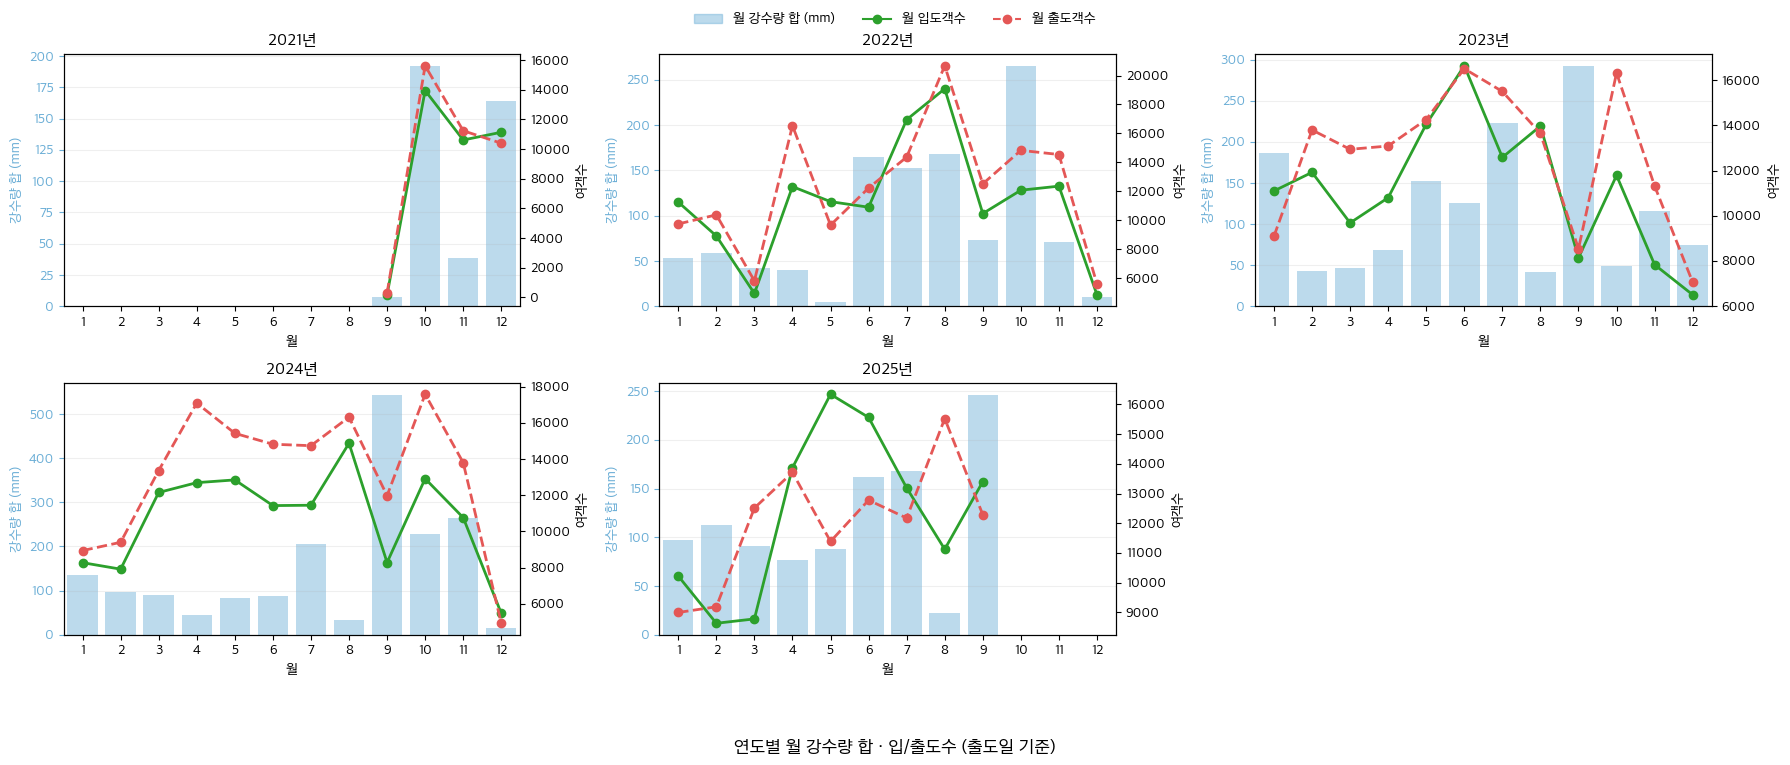

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# 1) 날씨 데이터 전처리

rain_df = pd.read_csv("2018.01.01-2025.10.31 강수량.csv", encoding="utf-8")
rain_df["날짜"] = pd.to_datetime(rain_df["날짜"], errors="coerce")
rain_df["강수량(mm)"] = pd.to_numeric(rain_df["강수량(mm)"], errors="coerce").fillna(0)
rain_df["강수량(mm)"] = rain_df["강수량(mm)"].clip(lower=0)
if "지점" in rain_df.columns:
    rain_df = rain_df.drop(columns=["지점"])

temp_df = pd.read_csv("울릉도_기온.csv", encoding="utf-8")
temp_df["날짜"] = pd.to_datetime(temp_df["날짜"], errors="coerce")
if "지점" in temp_df.columns:
    temp_df = temp_df.drop(columns=["지점"])

weather_df = pd.merge(rain_df, temp_df, on="날짜", how="inner")
for col in list(weather_df.columns):
    if "Unnamed" in col or col == "0":
        weather_df = weather_df.drop(columns=[col])


# 2) 여객 데이터 전처리

in_ppl = pd.read_csv("일별 여객 입항.csv", encoding="utf-8")
out_ppl = pd.read_csv("일별 여객 출항.csv", encoding="utf-8")

for df in (in_ppl, out_ppl):
    df["출항일"] = pd.to_datetime(df["출항일"], errors="coerce").dt.normalize()
    df["합계"] = pd.to_numeric(df["합계"], errors="coerce").fillna(0).astype(int)

in_p_day = (
    in_ppl.groupby("출항일", as_index=False)["합계"]
    .sum()
    .rename(columns={"출항일": "날짜", "합계": "입항_여객수"})
)
out_p_day = (
    out_ppl.groupby("출항일", as_index=False)["합계"]
    .sum()
    .rename(columns={"출항일": "날짜", "합계": "출항_여객수"})
)


# 3) 병합 (출항일 기준)

base_dates = pd.DataFrame(
    pd.Index(
        pd.concat([in_p_day["날짜"], out_p_day["날짜"]]).dropna().unique()
    ).sort_values(),
    columns=["날짜"],
)

merged = (
    base_dates.merge(weather_df, on="날짜", how="left")
    .merge(in_p_day, on="날짜", how="left")
    .merge(out_p_day, on="날짜", how="left")
)

for col in ["입항_여객수", "출항_여객수"]:
    merged[col] = merged[col].fillna(0).astype(int)


# 4) 월별 집계 + 연도별 패널 그래프

df = merged.copy()
df["날짜"] = pd.to_datetime(df["날짜"])

monthly = (
    df.set_index("날짜")
    .resample("MS")
    .agg(
        월강수합=("강수량(mm)", "sum"),
        월입항합=("입항_여객수", "sum"),
        월출항합=("출항_여객수", "sum"),
    )
)

mwrap = monthly.copy()
mwrap["연"] = mwrap.index.year
mwrap["월"] = mwrap.index.month

years = sorted(mwrap["연"].unique())
ncols = 3
nrows = math.ceil(len(years) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows), sharex=False)
axes = np.array(axes).reshape(nrows, ncols)

for i, y in enumerate(years):
    ax = axes.ravel()[i]
    ax2 = ax.twinx()

    sub = mwrap[mwrap["연"] == y].set_index("월").reindex(range(1, 13))

    # 막대: 월 강수량 합
    ax.bar(
        sub.index,
        sub["월강수합"],
        color="#6BAED6",
        alpha=0.45,
        label="월 강수량 합 (mm)",
    )

    # 라인: 월 입/출항 여객수
    ax2.plot(
        sub.index,
        sub["월입항합"],
        marker="o",
        linewidth=2,
        color="#2CA02C",
        label="월 입도객수",
    )
    ax2.plot(
        sub.index,
        sub["월출항합"],
        marker="o",
        linewidth=2,
        linestyle="--",
        color="#E45756",
        label="월 출도객수",
    )

    ax.set_title(f"{y}년")
    ax.set_xlim(0.5, 12.5)
    ax.set_xticks(range(1, 13))
    ax.set_xlabel("월")
    ax.set_ylabel("강수량 합 (mm)", color="#6BAED6")
    ax2.set_ylabel("여객수")

    ax.tick_params(axis="y", colors="#6BAED6")
    ax.grid(True, axis="y", alpha=0.2)

# 빈 패널 제거
for j in range(len(years), nrows * ncols):
    fig.delaxes(axes.ravel()[j])

legend_handles = [
    Patch(color="#6BAED6", alpha=0.45, label="월 강수량 합 (mm)"),
    Line2D([0], [0], color="#2CA02C", marker="o", label="월 입도객수"),
    Line2D([0], [0], color="#E45756", marker="o", linestyle="--", label="월 출도객수"),
]
fig.legend(handles=legend_handles, loc="upper center", ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0.14, 1, 0.98])
fig.text(
    0.5,
    0.06,
    "연도별 월 강수량 합 · 입/출도수 (출도일 기준)",
    ha="center",
    va="bottom",
    fontsize=13,
    fontweight="bold",
)
plt.show()